In this notebook, we will research cryptocurrencies prices for cointegration.

We have historical cryptocurrencies prices data parsed from Coinbase Pro exchange and sampled as minute bars.

In [1]:
%load_ext autoreload
%autoreload 2

from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import statsmodels.api as sm
from datetime import datetime
from matplotlib import style
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from tqdm import tqdm_notebook
from trading_calendars.always_open import AlwaysOpenCalendar

import utils

style.use("ggplot")

# Research Hyperparameters

In [2]:
RESEARCH_START_DATE = pd.Timestamp("2018-01-01")
COINTEGRATION_RESEARCH_DATE = pd.Timestamp("2018-10-01")

# Utils

In [3]:
def research_serieses_for_cointegration(data, det_order, k_ar_diff):
    johansen_results = coint_johansen(data.values, det_order=det_order, k_ar_diff=k_ar_diff)
    
    print("Eigen values:", johansen_results.eig)
    print("Eigen vectors:", johansen_results.evec)
    print()
    
    print("Trace Test")
    print("Trace Statistics:", johansen_results.lr1)
    print("CV for Trace Statistics:", johansen_results.cvt)
    print()
    
    print("Eigen Test")
    print("Eigen Statistics:", johansen_results.lr2)
    print("CV for Eigen Statistics:", johansen_results.cvm)

# Research 1 USD invested series

In [3]:
data = utils.combine_market_data("candles/", "USD", "open", True,
                                 file_names_to_exclude=["ZRX-USD.csv", "ETC-USD.csv",])
data.interpolate(inplace=True, method="linear")
data.head()

['ETH-USD.csv', 'BTC-USD.csv', 'BCH-USD.csv', 'LTC-USD.csv']


,ETH-USD,BTC-USD,BCH-USD,LTC-USD
time,,,,
2017-12-20 01:20:00,765.000000,16549.900000,3100.000000,320.140000
2017-12-20 01:21:00,765.970000,16504.950000,5300.000000,320.150000
2017-12-20 01:22:00,755.020000,16330.010000,4800.000000,311.960000
2017-12-20 01:23:00,755.071822,16330.592927,4799.555722,311.969669
2017-12-20 01:24:00,755.123645,16331.175855,4799.111445,311.979339


In [5]:
data = data.loc[RESEARCH_START_DATE:COINTEGRATION_RESEARCH_DATE]
row1 = data.iloc[0, :]
usd_invested = data.pct_change()
usd_invested.iloc[0, :] = 0
usd_invested += 1
usd_invested = usd_invested.cumprod(axis=0)
usd_invested.head()

,ETH-USD,BTC-USD,BCH-USD,LTC-USD
time,,,,
2018-01-01 00:00:00,1.000000,1.000000,1.000000,1.000000
2018-01-01 00:01:00,0.996978,1.000470,0.999341,1.002597
2018-01-01 00:02:00,0.998327,1.001197,0.999096,1.000880
2018-01-01 00:03:00,0.996803,0.999197,0.997085,0.998503
2018-01-01 00:04:00,0.997221,0.997061,0.999062,0.997139


In [108]:
usd_invested.drop(["BCH-USD"], axis=1, inplace=True)

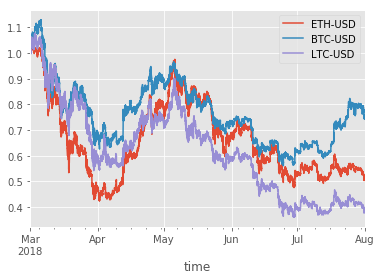

In [109]:
usd_invested.plot()

## Johansen Test

In [110]:
research_serieses_for_cointegration(usd_invested, 0, 1)

Eigen values: [2.51640490e-05 1.73286337e-05 7.98584799e-06]
Eigen vectors: [[ -0.8638838  -12.93015315  -2.8862034 ]
 [-12.20625719  14.24211074 -10.08026576]
 [  3.88018945  -0.60242764  11.98035049]]

Trace Test
Trace Statistics: [11.12148928  5.5773014   1.75944107]
CV for Trace Statistics: [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Eigen Test
Eigen Statistics: [5.54418788 3.81786033 1.75944107]
CV for Eigen Statistics: [[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


## Engle-Granger 2 Step Test

# Research min Coinbase Pro pieces prices

## Johansen Test

In [4]:
BTC_MIN = 0.001
BCH_MIN = 0.01
ETH_MIN = 0.01
LTC_MIN = 0.1
data = utils.combine_market_data("candles/", "USD", "open", True,
                                 file_names_to_exclude=["ZRX-USD.csv", "ETC-USD.csv",])
data.interpolate(inplace=True, method="linear")
data = data.loc[RESEARCH_START_DATE:]
data.head()

data["ETH-USD"] *= ETH_MIN
data["BTC-USD"] *= BTC_MIN
data["BCH-USD"] *= BCH_MIN
data["LTC-USD"] *= LTC_MIN

data = data.apply(lambda x: round(x, 3))

['ETH-USD.csv', 'BTC-USD.csv', 'BCH-USD.csv', 'LTC-USD.csv']


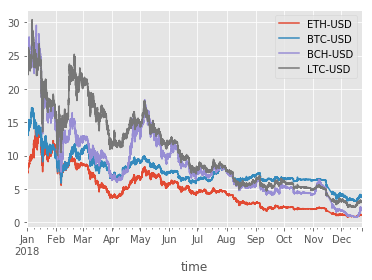

In [5]:
data.plot()

In [6]:
data.columns

Index(['ETH-USD', 'BTC-USD', 'BCH-USD', 'LTC-USD'], dtype='object')

In [9]:
research_serieses_for_cointegration(data[['BTC-USD', 'BCH-USD', 'ETH-USD']], 0, 5)

Eigen values: [8.50455602e-05 4.38083892e-05 1.34539059e-05]
Eigen vectors: [[ 0.24832115  1.14756794 -0.55175139]
 [ 0.35800371 -0.5626129   0.1170973 ]
 [-0.67676879  0.29344023  0.51935507]]

Trace Test
Trace Statistics: [55.94518708 22.51107995  5.2889678 ]
CV for Trace Statistics: [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Eigen Test
Eigen Statistics: [33.43410713 17.22211215  5.2889678 ]
CV for Eigen Statistics: [[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


## Engle-Granger 2 Step Test

In [6]:
utils.check_serieses_pairs_for_cointegration(data)

--------------------------
Pair ETH-USD and BTC-USD
Test Statistic: -3.656024423810873
P-Value: 0.020850585589441147
Critical values: [-3.89646139 -3.33614193 -3.04445828]
--------------------------
Pair ETH-USD and BCH-USD
Test Statistic: -5.333269990413249
P-Value: 3.837042679998764e-05
Critical values: [-3.89646139 -3.33614193 -3.04445828]
--------------------------
Pair ETH-USD and LTC-USD
Test Statistic: -3.7435336786639932
P-Value: 0.01609312636522419
Critical values: [-3.89646139 -3.33614193 -3.04445828]
--------------------------
Pair BTC-USD and BCH-USD
Test Statistic: -4.489113401051497
P-Value: 0.001276101667182467
Critical values: [-3.89646139 -3.33614193 -3.04445828]
--------------------------
Pair BTC-USD and LTC-USD
Test Statistic: -3.3815658539436027
P-Value: 0.04443959056044441
Critical values: [-3.89646139 -3.33614193 -3.04445828]
--------------------------
Pair BCH-USD and LTC-USD
Test Statistic: -3.766136133045843
P-Value: 0.01503125508253541
Critical values: [-3.89

Researching Pair BTC-USD and LTC-USD
Prices OLS results:
const: 3.7754517192034527 || LTC-USD 0.3577543246436745


/Users/nialeksandrov/virtualenvs/trading/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


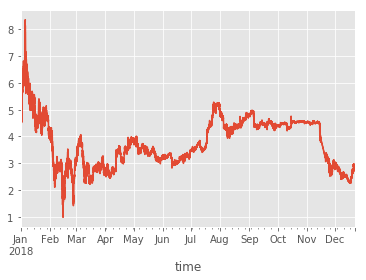

Diff of Cointegrating Series OLS Results:
const: 0.00019511683697702236 || -5.322558274453572e-05
Mean-Reverse Half-life: 13022.819945190842


In [7]:
utils.research_pair_trading_opportunity(data["BTC-USD"], data["LTC-USD"])

In [25]:
coint_series = data["BTC-USD"] - data["LTC-USD"] * 0.3577543246436745
win_sz = int(13022 * 0.01)
coint_z_scores = (coint_series - coint_series.rolling(win_sz).mean()) / coint_series.rolling(win_sz).std()

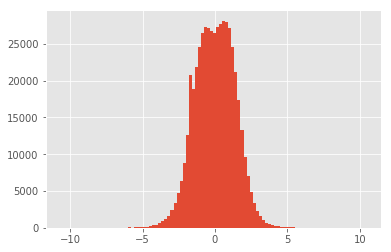

In [26]:
coint_z_scores.hist(bins=100)

Researching Pair BCH-USD and LTC-USD
Prices OLS results:
const: 0.20744134209996173 || LTC-USD 0.7987238260461774


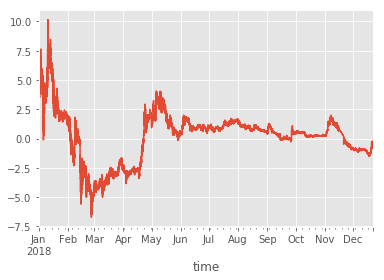

Diff of Cointegrating Series OLS Results:
const: 1.7575926502177914e-07 || -5.8225974899420604e-05
Mean-Reverse Half-life: 11904.432373305657


In [27]:
utils.research_pair_trading_opportunity(data["BCH-USD"], data["LTC-USD"])

## Research Log Prices For cointegration

In [65]:
data = utils.combine_market_data("candles/", "USD", "open", True,
                                 file_names_to_exclude=["ZRX-USD.csv", "ETC-USD.csv",])
data.interpolate(inplace=True, method="linear")
data = data.loc[RESEARCH_START_DATE:COINTEGRATION_RESEARCH_DATE]
data = np.log(data)
data.head()

,ETH-USD,BTC-USD,BCH-USD,LTC-USD
time,,,,
2018-07-01 00:00:00,6.116554,8.761423,6.618071,4.394573
2018-07-01 00:01:00,6.117083,8.761632,6.617002,4.394573
2018-07-01 00:02:00,6.117083,8.763270,6.617176,4.395683
2018-07-01 00:03:00,6.116554,8.765356,6.621099,4.395683
2018-07-01 00:04:00,6.116223,8.764053,6.620087,4.395683


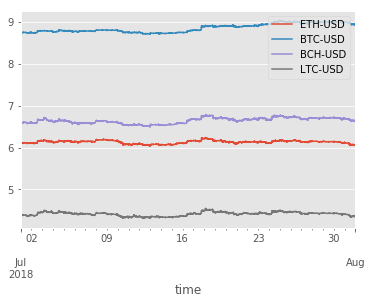

In [66]:
data.plot()

In [67]:
utils.check_serieses_pairs_for_cointegration(data)

--------------------------
Pair ETH-USD and BTC-USD
Test Statistic: -1.9257148046760073
P-Value: 0.566910006558058
Critical values: [-3.89668536 -3.33626688 -3.04454501]
--------------------------
Pair ETH-USD and BCH-USD
Test Statistic: -2.1231583764334974
P-Value: 0.464269008262407
Critical values: [-3.89668536 -3.33626688 -3.04454501]
--------------------------
Pair ETH-USD and LTC-USD
Test Statistic: -3.741763617313734
P-Value: 0.01617900355140371
Critical values: [-3.89668536 -3.33626688 -3.04454501]
--------------------------
Pair BTC-USD and BCH-USD
Test Statistic: -2.1206027471861013
P-Value: 0.4656031626907127
Critical values: [-3.89668536 -3.33626688 -3.04454501]
--------------------------
Pair BTC-USD and LTC-USD
Test Statistic: -0.7006702564511743
P-Value: 0.9465662527113525
Critical values: [-3.89668536 -3.33626688 -3.04454501]
--------------------------
Pair BCH-USD and LTC-USD
Test Statistic: -2.977721889465488
P-Value: 0.11559641440267121
Critical values: [-3.89668536 -

# Engle-Granger 2 Step Test

In [ ]:
ols_

# Conclusion 

As we can see there are a lot of cointegrating sets of pairs, whose linear combination is stationary in a short term time frame (within several hours).